# **F1 world championships analysis**

Imports & configuration

In [76]:
import os
from pathlib import Path
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from scipy import stats
import kagglehub
import geopandas as gpd
import numpy as np
from numpy.polynomial import Polynomial
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [77]:
!pip install -q kaggle

In [78]:
DATASET_PATH = kagglehub.dataset_download("rohanrao/formula-1-world-championship-1950-2020")

print("Path to dataset files:", DATASET_PATH)

Using Colab cache for faster access to the 'formula-1-world-championship-1950-2020' dataset.
Path to dataset files: /kaggle/input/formula-1-world-championship-1950-2020


In [79]:
print("Files in dataset folder:", os.listdir(DATASET_PATH))

Files in dataset folder: ['races.csv', 'constructor_results.csv', 'drivers.csv', 'constructors.csv', 'lap_times.csv', 'status.csv', 'driver_standings.csv', 'seasons.csv', 'pit_stops.csv', 'sprint_results.csv', 'constructor_standings.csv', 'results.csv', 'circuits.csv', 'qualifying.csv']


Load CSVs

In [80]:
dataframes = {}

dataframes = {}
for file in os.listdir(DATASET_PATH):
    if file.endswith(".csv"):
        name = file[:-4]
        fp = os.path.join(DATASET_PATH, file)
        dataframes[name] = pd.read_csv(fp)
        print(f"Loaded {file} -> DataFrame '{name}', rows={len(dataframes[name])}, columns={list(dataframes[name].columns)}")

Loaded races.csv -> DataFrame 'races', rows=1125, columns=['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time']
Loaded constructor_results.csv -> DataFrame 'constructor_results', rows=12625, columns=['constructorResultsId', 'raceId', 'constructorId', 'points', 'status']
Loaded drivers.csv -> DataFrame 'drivers', rows=861, columns=['driverId', 'driverRef', 'number', 'code', 'forename', 'surname', 'dob', 'nationality', 'url']
Loaded constructors.csv -> DataFrame 'constructors', rows=212, columns=['constructorId', 'constructorRef', 'name', 'nationality', 'url']
Loaded lap_times.csv -> DataFrame 'lap_times', rows=589081, columns=['raceId', 'driverId', 'lap', 'position', 'time', 'milliseconds']
Loaded status.csv -> DataFrame 'status', rows=139, columns=['statusId', 'status']
Loaded driver_standings.csv -> DataFrame 'driver_standings', rows=34863

Create SQLite connection and import tables

In [81]:
DB_PATH = 'f1_data.db'
conn = sqlite3.connect(DB_PATH)

for name, df in dataframes.items():
    df.to_sql(name, conn, if_exists="replace", index=False)
    print("Wrote table:", name, "rows:", len(df))

conn.commit()
print("SQLite DB written to", DB_PATH)

Wrote table: races rows: 1125
Wrote table: constructor_results rows: 12625
Wrote table: drivers rows: 861
Wrote table: constructors rows: 212
Wrote table: lap_times rows: 589081
Wrote table: status rows: 139
Wrote table: driver_standings rows: 34863
Wrote table: seasons rows: 75
Wrote table: pit_stops rows: 11371
Wrote table: sprint_results rows: 360
Wrote table: constructor_standings rows: 13391
Wrote table: results rows: 26759
Wrote table: circuits rows: 77
Wrote table: qualifying rows: 10494
SQLite DB written to f1_data.db


Show table list and basic schema

In [82]:
def show_tables(conn):
    q = "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;"
    tables = pd.read_sql(q, conn)
    return tables['name'].tolist()

def table_info(conn, table, n=5):
    df = pd.read_sql(f"SELECT * FROM {table} LIMIT {n}", conn)
    types = pd.read_sql(f"PRAGMA table_info('{table}')", conn)
    return df, types

In [83]:
tables = show_tables(conn)
print("Tables in DB:", tables)

Tables in DB: ['circuits', 'constructor_results', 'constructor_standings', 'constructors', 'driver_standings', 'drivers', 'lap_times', 'pit_stops', 'qualifying', 'races', 'results', 'results_clean', 'seasons', 'sprint_results', 'status']


In [84]:
for t in ['races', 'results', 'drivers', 'constructors', 'circuits', 'qualifying']:
    if t in tables:
        df, types = table_info(conn, t, n=3)
        print("\n=== Table:", t, "sample rows ===")
        display(df)
        print("Schema for", t)
        display(types)


=== Table: races sample rows ===


,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


Schema for races


,cid,name,type,notnull,dflt_value,pk
0,0,raceId,INTEGER,0,None,0
1,1,year,INTEGER,0,None,0
2,2,round,INTEGER,0,None,0
3,3,circuitId,INTEGER,0,None,0
4,4,name,TEXT,0,None,0
5,5,date,TEXT,0,None,0
6,6,time,TEXT,0,None,0
7,7,url,TEXT,0,None,0
8,8,fp1_date,TEXT,0,None,0
9,9,fp1_time,TEXT,0,None,0



=== Table: results sample rows ===


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1


Schema for results


,cid,name,type,notnull,dflt_value,pk
0,0,resultId,INTEGER,0,None,0
1,1,raceId,INTEGER,0,None,0
2,2,driverId,INTEGER,0,None,0
3,3,constructorId,INTEGER,0,None,0
4,4,number,TEXT,0,None,0
5,5,grid,INTEGER,0,None,0
6,6,position,TEXT,0,None,0
7,7,positionText,TEXT,0,None,0
8,8,positionOrder,INTEGER,0,None,0
9,9,points,REAL,0,None,0



=== Table: drivers sample rows ===


,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg


Schema for drivers


,cid,name,type,notnull,dflt_value,pk
0,0,driverId,INTEGER,0,None,0
1,1,driverRef,TEXT,0,None,0
2,2,number,TEXT,0,None,0
3,3,code,TEXT,0,None,0
4,4,forename,TEXT,0,None,0
5,5,surname,TEXT,0,None,0
6,6,dob,TEXT,0,None,0
7,7,nationality,TEXT,0,None,0
8,8,url,TEXT,0,None,0



=== Table: constructors sample rows ===


,constructorId,constructorRef,name,nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...


Schema for constructors


,cid,name,type,notnull,dflt_value,pk
0,0,constructorId,INTEGER,0,None,0
1,1,constructorRef,TEXT,0,None,0
2,2,name,TEXT,0,None,0
3,3,nationality,TEXT,0,None,0
4,4,url,TEXT,0,None,0



=== Table: circuits sample rows ===


,circuitId,circuitRef,name,location,country,lat,lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.9680,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.7380,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.5106,7,http://en.wikipedia.org/wiki/Bahrain_Internati...


Schema for circuits


,cid,name,type,notnull,dflt_value,pk
0,0,circuitId,INTEGER,0,None,0
1,1,circuitRef,TEXT,0,None,0
2,2,name,TEXT,0,None,0
3,3,location,TEXT,0,None,0
4,4,country,TEXT,0,None,0
5,5,lat,REAL,0,None,0
6,6,lng,REAL,0,None,0
7,7,alt,INTEGER,0,None,0
8,8,url,TEXT,0,None,0



=== Table: qualifying sample rows ===


,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079


Schema for qualifying


,cid,name,type,notnull,dflt_value,pk
0,0,qualifyId,INTEGER,0,None,0
1,1,raceId,INTEGER,0,None,0
2,2,driverId,INTEGER,0,None,0
3,3,constructorId,INTEGER,0,None,0
4,4,number,INTEGER,0,None,0
5,5,position,INTEGER,0,None,0
6,6,q1,TEXT,0,None,0
7,7,q2,TEXT,0,None,0
8,8,q3,TEXT,0,None,0


Function to run SQL

In [85]:
def run_sql(sql, conn=conn):
    try:
        return pd.read_sql(sql, conn)
    except Exception as e:
        print("SQL error:", e)
        raise

Create view v_results_full




In [86]:
cur = conn.cursor()

cur.executescript("""
DROP VIEW IF EXISTS v_results_full;
CREATE VIEW v_results_full AS
SELECT r.*,
       dr.forename || ' ' || dr.surname AS driver_name,
       co.name AS constructor_name,
       ci.name AS circuit_name,
       ra.name AS race_name,
       ra.year AS season,
       ra.date AS race_date,
       ra.time AS race_time,
       ra.round AS round
FROM results r
LEFT JOIN drivers dr ON r.driverId = dr.driverId
LEFT JOIN constructors co ON r.constructorId = co.constructorId
LEFT JOIN races ra ON r.raceId = ra.raceId
LEFT JOIN circuits ci ON ra.circuitId = ci.circuitId
;
""")

conn.commit()
print("Created view: v_results_full")

Created view: v_results_full


 Top drivers by career wins & podiums

In [87]:
sql_top_winners = """
SELECT driver_name, r.driverId, COUNT(*) as wins
FROM v_results_full r
WHERE CAST(r.positionOrder AS INTEGER) = 1
GROUP BY r.driverId
ORDER BY wins DESC
LIMIT 25;
"""

top_winners = run_sql(sql_top_winners)
display(top_winners.head(10))

,driver_name,driverId,wins
0,Lewis Hamilton,1,105
1,Michael Schumacher,30,91
2,Max Verstappen,830,63
3,Sebastian Vettel,20,53
4,Alain Prost,117,51
5,Ayrton Senna,102,41
6,Fernando Alonso,4,32
7,Nigel Mansell,95,31
8,Jackie Stewart,328,27
9,Jim Clark,373,25


In [88]:
sql_top_podiums = """
SELECT driver_name, driverId,
  SUM(CASE WHEN CAST(positionOrder AS INTEGER) IN (1) THEN 1 ELSE 0 END) AS wins,
  SUM(CASE WHEN CAST(positionOrder AS INTEGER) IN (1,2,3) THEN 1 ELSE 0 END) AS podiums,
  COUNT(*) AS starts
FROM v_results_full
GROUP BY driverId
ORDER BY podiums DESC
LIMIT 25;
"""

top_podiums = run_sql(sql_top_podiums)
display(top_podiums.head(10))

,driver_name,driverId,wins,podiums,starts
0,Lewis Hamilton,1,105,202,356
1,Michael Schumacher,30,91,155,308
2,Sebastian Vettel,20,53,122,300
3,Max Verstappen,830,63,112,209
4,Alain Prost,117,51,106,202
5,Fernando Alonso,4,32,106,404
6,Kimi Räikkönen,8,21,103,352
7,Ayrton Senna,102,41,80,162
8,Rubens Barrichello,22,11,68,326
9,Valtteri Bottas,822,10,67,247


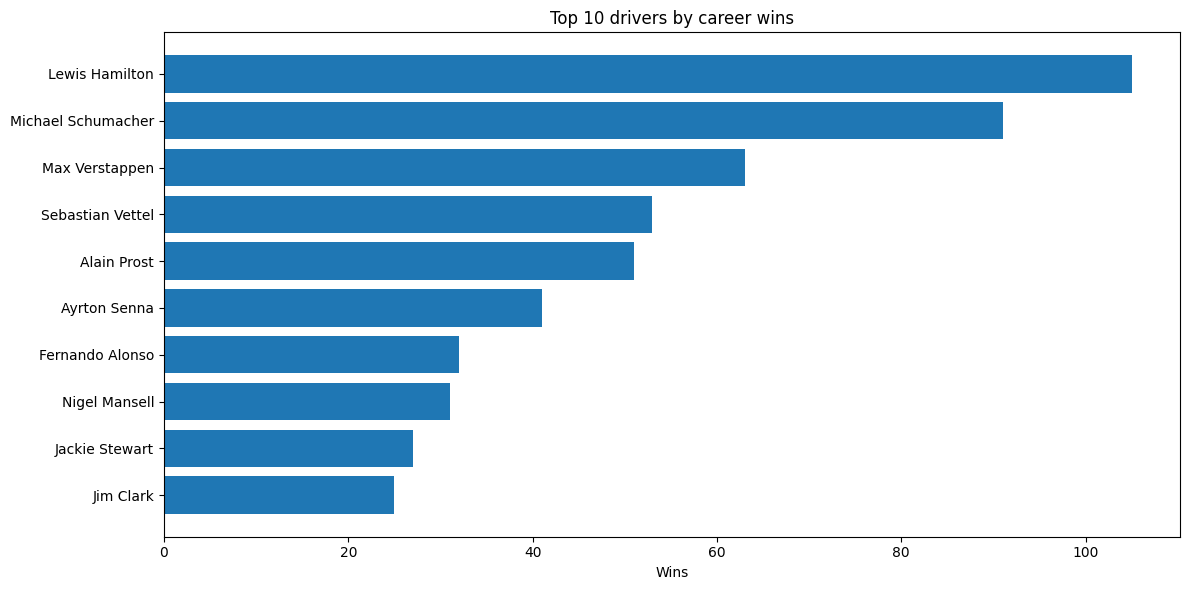

In [89]:
fig, ax = plt.subplots(figsize=(12,6))
ax.barh(top_winners['driver_name'].iloc[:10][::-1], top_winners['wins'].iloc[:10][::-1])
ax.set_title('Top 10 drivers by career wins')
ax.set_xlabel('Wins')
plt.tight_layout()
plt.show()

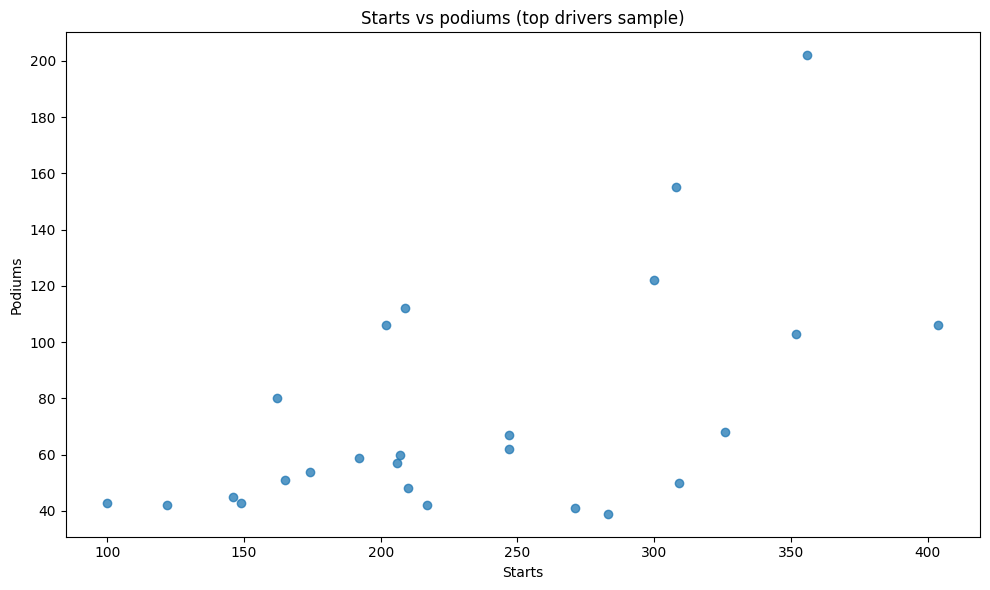

In [90]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(top_podiums['starts'], top_podiums['podiums'], alpha=0.75)
ax.set_xlabel('Starts')
ax.set_ylabel('Podiums')
ax.set_title('Starts vs podiums (top drivers sample)')
plt.tight_layout()
plt.show()

Cumulative wins over seasons for selected drivers

In [91]:
sql_driver_wins = """
SELECT season, driver_name, COUNT(*) AS wins
FROM v_results_full
WHERE CAST(positionOrder AS INTEGER) = 1
GROUP BY season, driver_name
ORDER BY season;
"""

driver_wins = run_sql(sql_driver_wins)
top5_drivers = (driver_wins.groupby('driver_name')['wins'].sum().sort_values(ascending=False).head(6).index.tolist())
print("Top drivers (by wins):", top5_drivers)

Top drivers (by wins): ['Lewis Hamilton', 'Michael Schumacher', 'Max Verstappen', 'Sebastian Vettel', 'Alain Prost', 'Ayrton Senna']


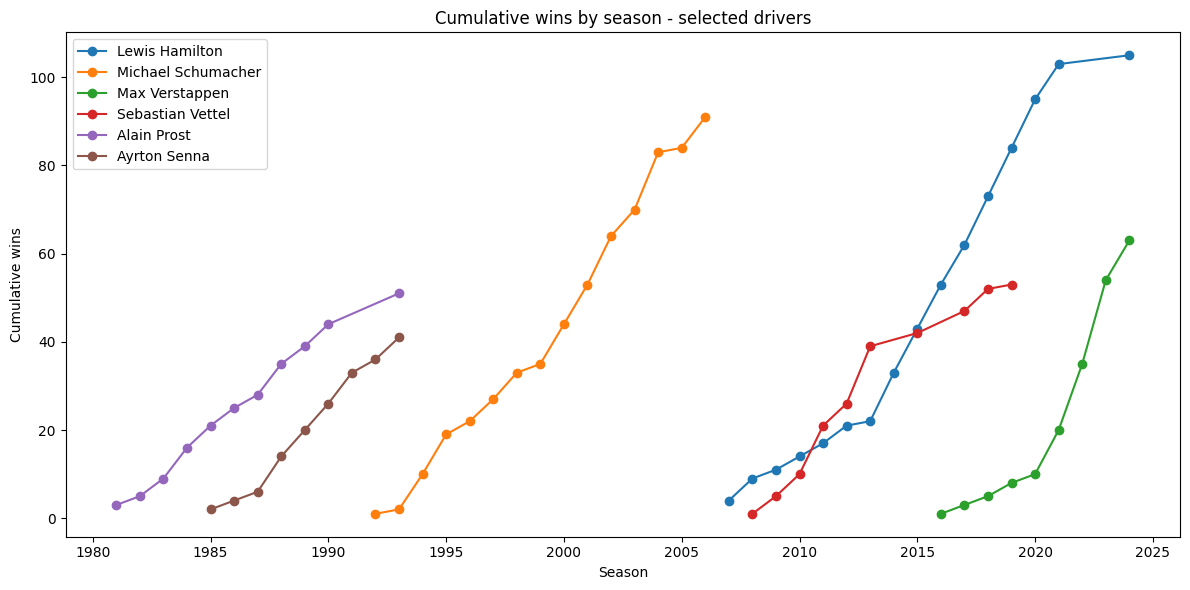

In [92]:
fig, ax = plt.subplots(figsize=(12,6))
for d in top5_drivers:
    df = driver_wins[driver_wins['driver_name'] == d].sort_values('season')
    if df.empty:
        continue
    ax.plot(df['season'], df['wins'].cumsum(), marker='o', label=d)
ax.set_title('Cumulative wins by season - selected drivers')
ax.set_xlabel('Season')
ax.set_ylabel('Cumulative wins')
ax.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

Constructor championships (season totals)

In [93]:
sql_constructors = """
SELECT season, constructor_name, SUM(points) AS total_points
FROM v_results_full
GROUP BY season, constructor_name
ORDER BY season, total_points DESC;
"""

df = run_sql(sql_constructors)
top_constructor_per_season = df.sort_values(['season','total_points'], ascending=[True,False]).groupby('season').first().reset_index()
display(top_constructor_per_season.head(10))

,season,constructor_name,total_points
0,1950,Alfa Romeo,89.00
1,1951,Ferrari,86.00
2,1952,Ferrari,120.50
3,1953,Ferrari,122.50
4,1954,Ferrari,80.28
5,1955,Mercedes,79.00
6,1956,Ferrari,82.00
7,1957,Maserati,78.00
8,1958,Ferrari,93.00
9,1959,Cooper-Climax,97.50


Qualifying vs race finish analysis

In [117]:
sql_qual_vs_race = """
SELECT q.raceId, q.driverId, dr.forename || ' ' || dr.surname AS driver_name,
       q.position AS qualifying_pos,
       r.position AS finish_pos,
       r.constructor_name,
       r.season
FROM qualifying q
JOIN v_results_full r
    ON q.raceId = r.raceId AND q.driverId = r.driverId
LEFT JOIN drivers dr
    ON q.driverId = dr.driverId
WHERE q.position IS NOT NULL AND r.position IS NOT NULL
LIMIT 1000;
"""

qual_vs_race = run_sql(sql_qual_vs_race)
display(qual_vs_race.head())


,raceId,driverId,driver_name,qualifying_pos,finish_pos,constructor_name,season
0,18,1,Lewis Hamilton,1,1,McLaren,2008
1,18,9,Robert Kubica,2,\N,BMW Sauber,2008
2,18,5,Heikki Kovalainen,3,5,McLaren,2008
3,18,13,Felipe Massa,4,\N,Ferrari,2008
4,18,2,Nick Heidfeld,5,2,BMW Sauber,2008


Correlation: grid position vs final position

In [95]:
sql_grid_final = """
SELECT CAST(grid AS INTEGER) AS grid, CAST(positionOrder AS INTEGER) AS final_pos, season
FROM v_results_full
WHERE grid IS NOT NULL AND trim(grid) <> '' AND positionOrder IS NOT NULL AND trim(positionOrder) <> ''
"""

grid_final = run_sql(sql_grid_final)
grid_final = grid_final.dropna(subset=['grid','final_pos'])
grid_final = grid_final[(grid_final['grid'] > 0) & (grid_final['final_pos'] > 0) & (grid_final['grid'] < 50) & (grid_final['final_pos'] < 50)]

pearson_r, pearson_p = stats.pearsonr(grid_final['grid'], grid_final['final_pos'])
spearman_r, spearman_p = stats.spearmanr(grid_final['grid'], grid_final['final_pos'])
print(f"Grid vs final: Pearson r = {pearson_r:.3f} (p={pearson_p:.3e}), Spearman rho = {spearman_r:.3f} (p={spearman_p:.3e})")

Grid vs final: Pearson r = 0.446 (p=0.000e+00), Spearman rho = 0.457 (p=0.000e+00)


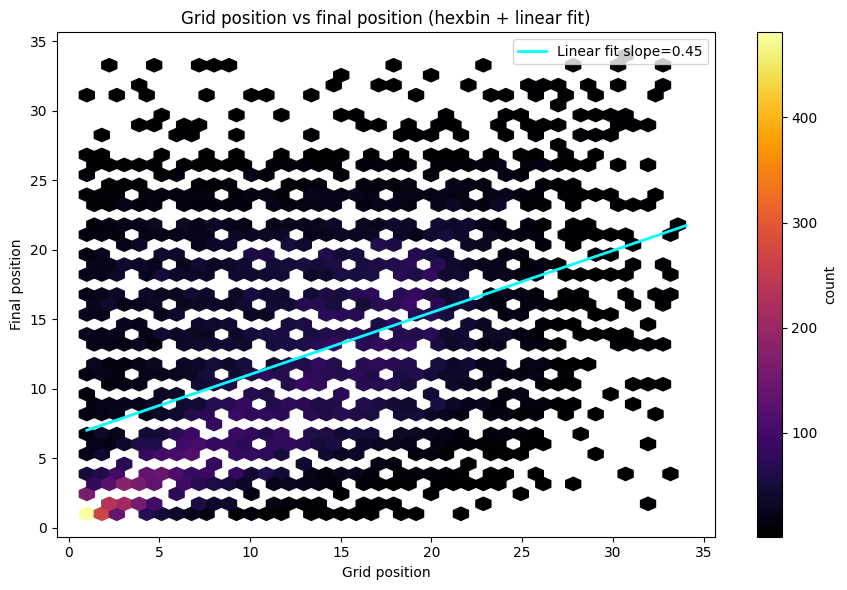

In [96]:
fig, ax = plt.subplots(figsize=(9,6))
hb = ax.hexbin(grid_final['grid'], grid_final['final_pos'], gridsize=40, mincnt=1, cmap='inferno')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('count')
slope, intercept, r_val, p_val, std_err = stats.linregress(grid_final['grid'], grid_final['final_pos'])
xs = np.array([grid_final['grid'].min(), grid_final['grid'].max()])
ax.plot(xs, intercept + slope*xs, color='cyan', linewidth=2, label=f'Linear fit slope={slope:.2f}')
ax.set_xlabel('Grid position')
ax.set_ylabel('Final position')
ax.set_title('Grid position vs final position (hexbin + linear fit)')
ax.legend()
plt.tight_layout()
plt.show()

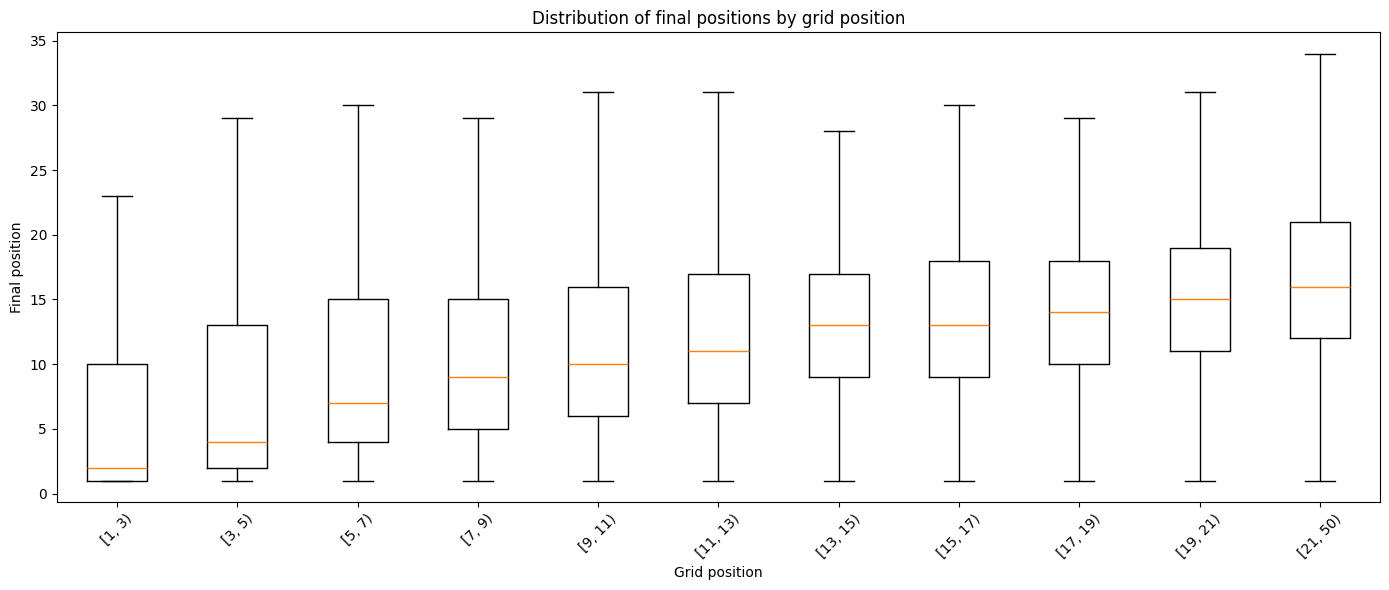

In [118]:
grid_final['grid_bucket'] = pd.cut(grid_final['grid'], bins=list(range(1,22,2))+[50], right=False)
grouped = grid_final.groupby('grid_bucket', observed=False)['final_pos']
labels = [str(b) for b in grouped.groups.keys()]
data = [grouped.get_group(b).values if b in grouped.groups else np.array([]) for b in grouped.groups.keys()]

fig, ax = plt.subplots(figsize=(14,6))
ax.boxplot(data, tick_labels=labels, showfliers=False)
ax.set_title('Distribution of final positions by grid position')
ax.set_xlabel('Grid position')
ax.set_ylabel('Final position')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 Qualifying -> race: drivers who gain the most positions

In [98]:
sql_advancers = """
SELECT dr.forename || ' ' || dr.surname as driver_name,
       AVG(CAST(r.positionOrder AS INTEGER) - CAST(q.position AS INTEGER)) AS avg_pos_change,
       COUNT(*) as races_compared
FROM qualifying q
JOIN v_results_full r
    ON q.raceId = r.raceId AND q.driverId = r.driverId
LEFT JOIN drivers dr
    ON q.driverId = dr.driverId
WHERE q.position IS NOT NULL AND q.position <> '' AND r.positionOrder IS NOT NULL AND r.positionOrder <> ''
GROUP BY q.driverId
HAVING COUNT(*) >= 30
ORDER BY avg_pos_change ASC
LIMIT 25;
"""

advancers = run_sql(sql_advancers)
display(advancers)

,driver_name,avg_pos_change,races_compared
0,Pedro Diniz,-4.854167,48
1,Tiago Monteiro,-3.621622,37
2,Mika Salo,-3.120000,50
3,Charles Pic,-2.846154,39
4,Christijan Albers,-2.804348,46
5,Max Chilton,-2.742857,35
6,Felipe Nasr,-2.700000,40
7,Marcus Ericsson,-2.520833,96
8,Narain Karthikeyan,-2.382979,47
9,Pascal Wehrlein,-2.153846,39


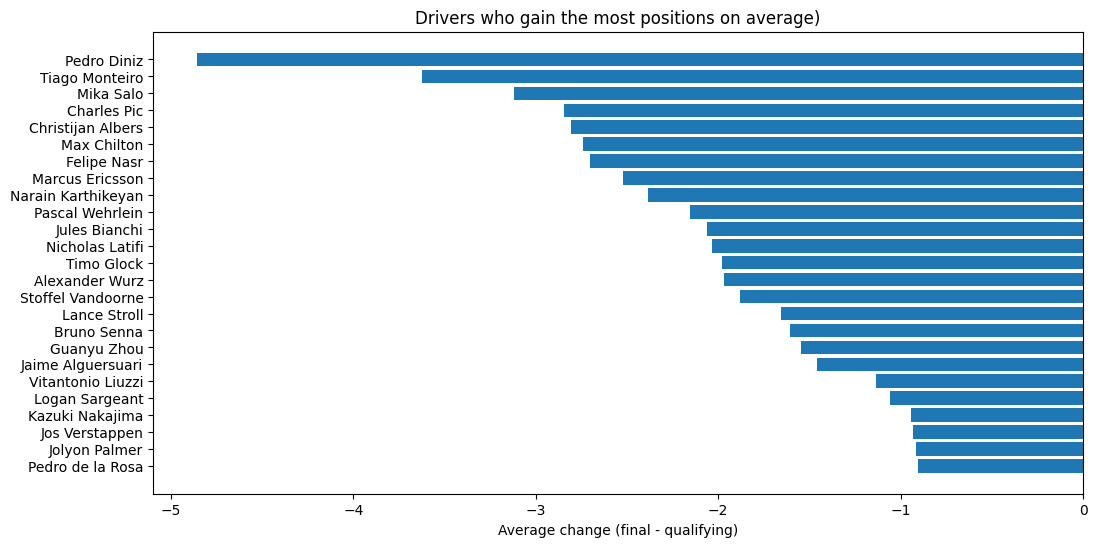

In [119]:
fig, ax = plt.subplots(figsize=(12,6))
ax.barh(advancers['driver_name'].iloc[::-1], advancers['avg_pos_change'].iloc[::-1])
ax.set_title('Drivers who gain the most positions on average)')
ax.set_xlabel('Average change (final - qualifying)')
plt.show()

Pit stops: average duration per driver

In [100]:
sql_pit = """
SELECT dr.forename || ' ' || dr.surname AS driver_name,
       COUNT(*) AS pit_counts,
       AVG(duration) AS avg_duration_text,
       AVG(milliseconds) AS avg_ms
FROM pit_stops p
LEFT JOIN drivers dr ON p.driverId = dr.driverId
GROUP BY p.driverId
HAVING COUNT(*) >= 20
ORDER BY avg_ms ASC
LIMIT 30;
"""

pit_avg = run_sql(sql_pit)
display(pit_avg)


,driver_name,pit_counts,avg_duration_text,avg_ms
0,Michael Schumacher,90,22.541644,22541.644444
1,Nick Heidfeld,25,22.933320,22933.320000
2,Mark Webber,142,22.429493,23556.549296
3,Vitaly Petrov,87,23.694161,23694.160920
4,Timo Glock,75,23.743947,23743.946667
5,Jaime Alguersuari,43,23.862349,23862.348837
6,Bruno Senna,61,23.938557,23938.557377
7,Brendon Hartley,34,23.993912,23993.911765
8,Sébastien Buemi,41,24.024317,24024.317073
9,Paul di Resta,127,23.130528,24084.259843


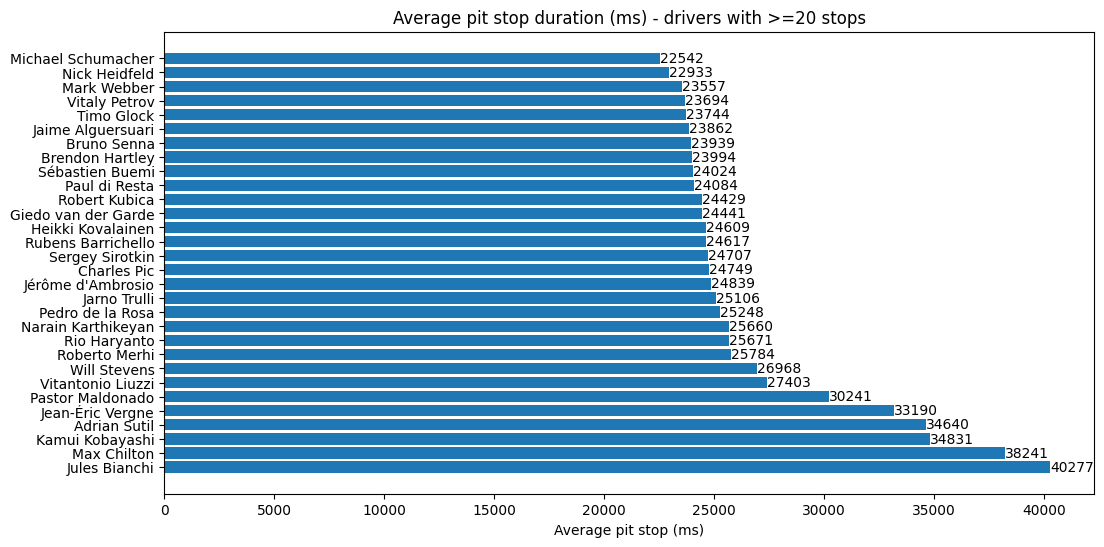

In [120]:
fig, ax = plt.subplots(figsize=(12,6))
bars = ax.barh(pit_avg['driver_name'].iloc[::-1], pit_avg['avg_ms'].iloc[::-1])
ax.set_title('Average pit stop duration (ms) - drivers with >=20 stops')
ax.set_xlabel('Average pit stop (ms)')
ax.bar_label(bars, fmt='%.0f')
plt.show()

Fastest laps (recent sample)

In [102]:
sql_fastest = """
SELECT season, race_name, driver_name, positionOrder AS final_pos, fastestLap, fastestLapSpeed
FROM v_results_full
WHERE fastestLap IS NOT NULL AND trim(fastestLap) <> ''
ORDER BY season DESC, race_date DESC
LIMIT 50;
"""

fastest = run_sql(sql_fastest)
display(fastest.head(10))

,season,race_name,driver_name,final_pos,fastestLap,fastestLapSpeed
0,2024,Abu Dhabi Grand Prix,Lando Norris,1,52,217.429
1,2024,Abu Dhabi Grand Prix,Carlos Sainz,2,55,216.619
2,2024,Abu Dhabi Grand Prix,Charles Leclerc,3,51,215.996
3,2024,Abu Dhabi Grand Prix,Lewis Hamilton,4,44,217.828
4,2024,Abu Dhabi Grand Prix,George Russell,5,56,215.563
5,2024,Abu Dhabi Grand Prix,Max Verstappen,6,56,216.619
6,2024,Abu Dhabi Grand Prix,Pierre Gasly,7,30,213.012
7,2024,Abu Dhabi Grand Prix,Nico Hülkenberg,8,17,213.249
8,2024,Abu Dhabi Grand Prix,Fernando Alonso,9,51,216.168
9,2024,Abu Dhabi Grand Prix,Oscar Piastri,10,51,216.804


Lap times: average lap time per driver (using milliseconds)

In [103]:
lap_schema = run_sql("SELECT * FROM lap_times LIMIT 0")
print("lap_times columns:", lap_schema.columns.tolist())

lap_times columns: ['raceId', 'driverId', 'lap', 'position', 'time', 'milliseconds']


In [104]:
sql_laptimes = """
SELECT raceId, driverId, lap, milliseconds
FROM lap_times
WHERE milliseconds IS NOT NULL
"""

lap_times = run_sql(sql_laptimes)
print("Loaded lap_times rows:", len(lap_times))

Loaded lap_times rows: 589081


In [105]:
avg_lap_ms = lap_times.groupby('driverId')['milliseconds'].agg(['count','mean']).reset_index().rename(columns={'count':'laps','mean':'avg_ms'})
drivers_df = run_sql("SELECT driverId, forename || ' ' || surname as driver_name FROM drivers")
avg_lap_ms = avg_lap_ms.merge(drivers_df, on='driverId', how='left')
avg_lap_ms = avg_lap_ms[avg_lap_ms['laps'] >= 500].sort_values('avg_ms').head(30)
display(avg_lap_ms[['driver_name','laps','avg_ms']])

,driver_name,laps,avg_ms
42,Cristiano da Matta,1484,86875.075472
30,Juan Pablo Montoya,4917,86976.960138
65,Allan McNish,639,87315.032864
53,Luciano Burti,668,88575.052395
25,Scott Speed,1285,89131.074708
51,Ralph Firman,639,89165.956182
44,Giorgio Pantano,549,89550.812386
13,David Coulthard,11211,89663.810722
50,Justin Wilson,670,89954.638806
34,Jacques Villeneuve,8314,90217.315131


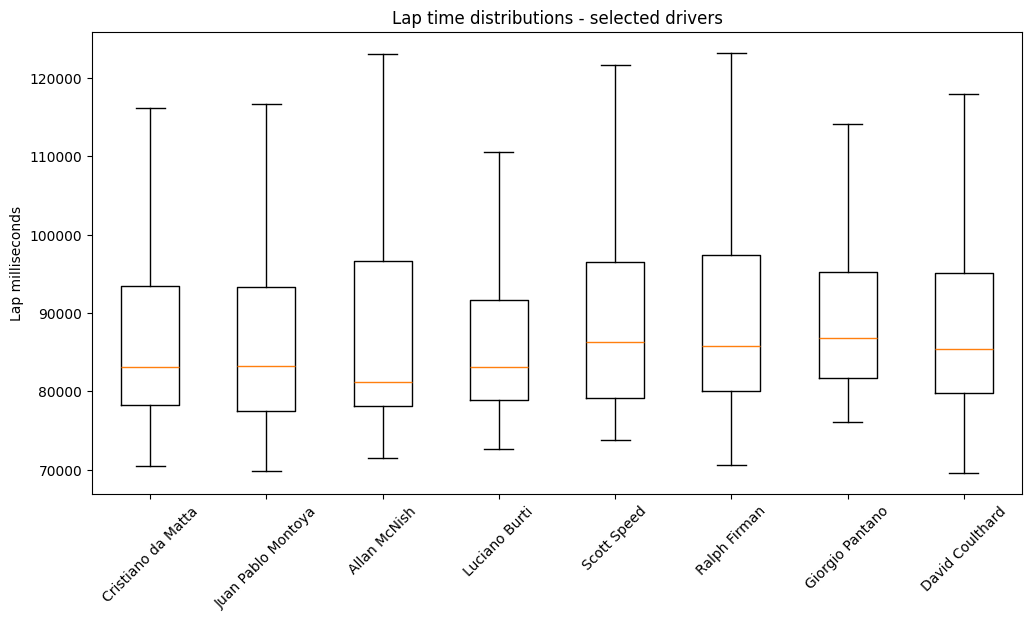

In [106]:
top_drivers_for_lap = avg_lap_ms['driverId'].head(8).tolist()
subset = lap_times[lap_times['driverId'].isin(top_drivers_for_lap)].merge(drivers_df, on='driverId', how='left')
fig, ax = plt.subplots(figsize=(12,6))
subset_box = [subset[subset['driverId'] == d]['milliseconds'].values for d in top_drivers_for_lap]
labels = [subset[subset['driverId'] == d]['driver_name'].iloc[0] for d in top_drivers_for_lap]
ax.boxplot(subset_box, tick_labels=labels, showfliers=False)
ax.set_title('Lap time distributions - selected drivers')
ax.set_ylabel('Lap milliseconds')
plt.xticks(rotation=45)
plt.show()

Circuits by country

In [107]:
sql_circuits_country = """
SELECT c.country, COUNT(*) AS race_count
FROM races ra
JOIN circuits c ON ra.circuitId = c.circuitId
GROUP BY c.country
ORDER BY race_count DESC;
"""

circuits_by_country = run_sql(sql_circuits_country)
display(circuits_by_country.head(30))

,country,race_count
0,Italy,107
1,UK,79
2,Germany,79
3,USA,77
4,Monaco,70
5,Belgium,69
6,France,63
7,Spain,61
8,Canada,53
9,Brazil,51


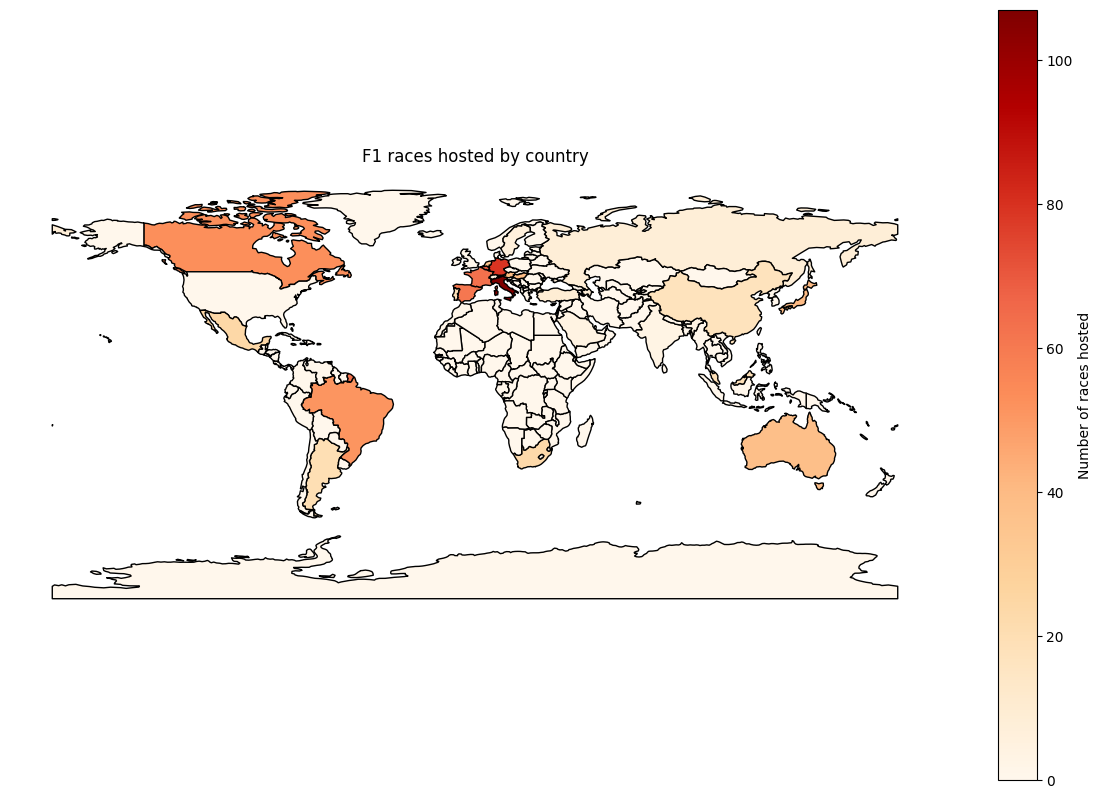

In [121]:
url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

merged = world.set_index('ADMIN').join(circuits_by_country.set_index('country'))

merged['race_count'] = merged['race_count'].fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.plot(column='race_count', ax=ax, legend=True,
            legend_kwds={'label': "Number of races hosted"},
            cmap='OrRd', edgecolor='black')

ax.set_title('F1 races hosted by country')
ax.set_axis_off()
plt.show()


 Decade-level analysis: how F1 changed across decades

In [109]:
cur.executescript("""
DROP TABLE IF EXISTS results_clean;
CREATE TABLE results_clean AS
SELECT *,
       CASE WHEN trim(positionOrder) = '' THEN NULL ELSE CAST(positionOrder AS INTEGER) END AS pos_order_num,
       CASE WHEN trim(grid) = '' THEN NULL ELSE CAST(grid AS INTEGER) END AS grid_num,
       CASE WHEN trim(points) = '' THEN 0.0 ELSE CAST(points AS REAL) END AS points_num,
       CASE WHEN trim(milliseconds) = '' THEN NULL ELSE CAST(milliseconds AS INTEGER) END AS ms
FROM v_results_full;
""")

conn.commit()

In [110]:
sql_decade_metrics = """
SELECT ((season/10)*10) AS decade,
       COUNT(*) AS entries,
       AVG(points_num) AS avg_points_per_entry,
       AVG(pos_order_num) AS avg_final_pos,
       SUM(CASE WHEN pos_order_num IS NOT NULL THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS pct_recorded_finish
FROM results_clean
WHERE season IS NOT NULL
GROUP BY decade
ORDER BY decade;
"""

decade_metrics = run_sql(sql_decade_metrics)
display(decade_metrics)

,decade,entries,avg_points_per_entry,avg_final_pos,pct_recorded_finish
0,1950,2007,1.001769,12.470354,1.0
1,1960,2113,1.171794,11.602461,1.0
2,1970,3807,0.938797,13.935382,1.0
3,1980,4503,0.860426,15.217855,1.0
4,1990,4250,0.984235,14.038588,1.0
5,2000,3643,1.674581,10.993961,1.0
6,2010,4297,4.681871,11.419362,1.0
7,2020,2139,5.072698,10.495559,1.0


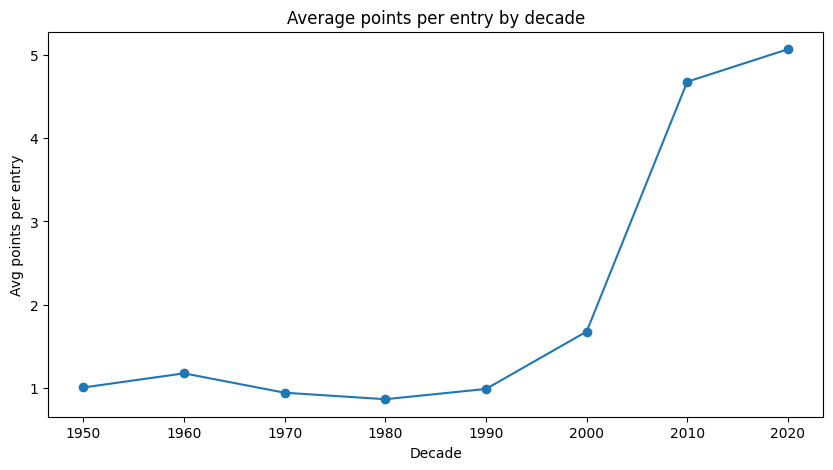

In [111]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(decade_metrics['decade'], decade_metrics['avg_points_per_entry'], marker='o')
ax.set_title('Average points per entry by decade')
ax.set_xlabel('Decade')
ax.set_ylabel('Avg points per entry')
plt.show()

In [112]:
sql_pole_to_win = """
WITH poles AS (
    SELECT raceId, season, driverId AS pole_driver
    FROM results_clean
    WHERE grid_num = 1
),
wins AS (
    SELECT raceId, season, driverId AS win_driver
    FROM results_clean
    WHERE pos_order_num = 1
)
SELECT ((p.season/10)*10) AS decade,
       AVG(CASE WHEN p.pole_driver = w.win_driver THEN 1.0 ELSE 0.0 END) AS pct_pole_to_win,
       COUNT(p.raceId) AS pole_count
FROM poles p
LEFT JOIN wins w ON p.raceId = w.raceId
GROUP BY decade
ORDER BY decade;
"""

pole_to_win = run_sql(sql_pole_to_win)
display(pole_to_win)

,decade,pct_pole_to_win,pole_count
0,1950,0.408163,98
1,1960,0.362745,102
2,1970,0.368056,144
3,1980,0.282051,156
4,1990,0.425926,162
5,2000,0.500000,174
6,2010,0.505051,198
7,2020,0.523364,107


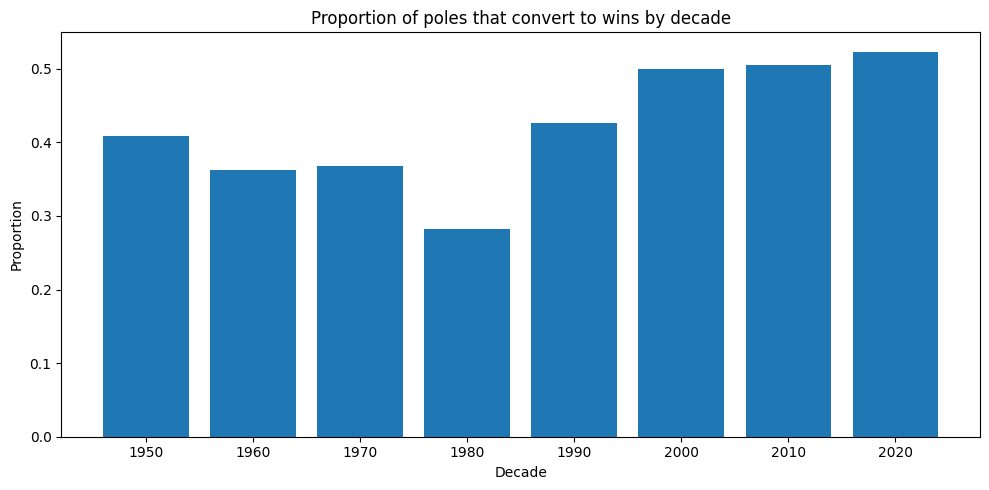

In [113]:
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(pole_to_win['decade'].astype(str), pole_to_win['pct_pole_to_win'])
ax.set_title('Proportion of poles that convert to wins by decade')
ax.set_xlabel('Decade')
ax.set_ylabel('Proportion')
plt.tight_layout()
plt.show()

Prepare data for modelling

In [114]:
sql_avg_points_per_season = """
SELECT season, AVG(points_num) AS avg_points
FROM results_clean
WHERE season IS NOT NULL
GROUP BY season
ORDER BY season;
"""

df_avg_points = run_sql(sql_avg_points_per_season)

X = df_avg_points['season'].values
y = df_avg_points['avg_points'].values

Polynomial regression (degree 5)

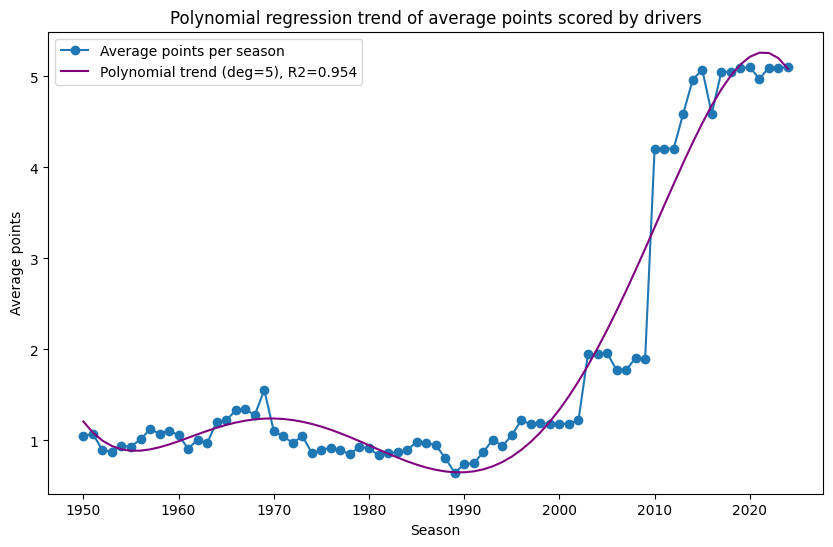

Polynomial regression coefficients: [-9.23089750e-08  9.15716684e-04 -3.63342133e+00  7.20805285e+03
 -7.14937122e+06  2.83632192e+09]


In [115]:
coefs = np.polyfit(X, y, deg=5)
poly_trend = np.polyval(coefs, X)

r2_poly = r2_score(y, poly_trend)

plt.figure(figsize=(10,6))
plt.plot(X, y, marker='o', label='Average points per season')
plt.plot(X, poly_trend, color='purple', label=f'Polynomial trend (deg=5), R2={r2_poly:.3f}')
plt.title('Polynomial regression trend of average points scored by drivers')
plt.xlabel('Season')
plt.ylabel('Average points')
plt.legend()
plt.show()

print("Polynomial regression coefficients:", coefs)

LOWESS smoothing


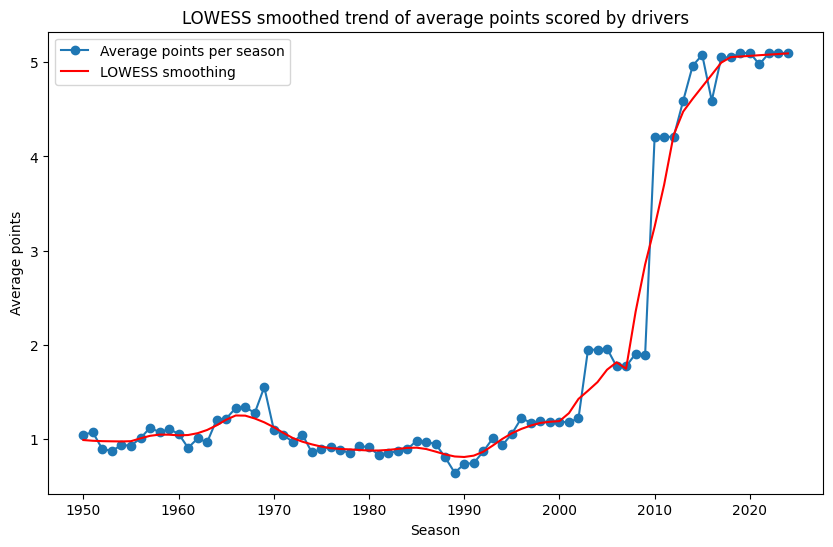

In [116]:
lowess = sm.nonparametric.lowess
y_smooth = lowess(y, X, frac=0.15)

plt.figure(figsize=(10,6))
plt.plot(X, y, marker='o', label='Average points per season')
plt.plot(y_smooth[:,0], y_smooth[:,1], color='red', label='LOWESS smoothing')
plt.title('LOWESS smoothed trend of average points scored by drivers')
plt.xlabel('Season')
plt.ylabel('Average points')
plt.legend()
plt.show()